# Cross Validation

In this notebook, I validate choices using cross validation.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

import aviary as av
import astropy.modeling as apm

from tqdm import trange
import pickle

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
class AgePosterior(object):

    def __init__(self, filename):
        
        # Load the saved GP gyro model
        with open(filename, "rb") as f:
            model, map_soln = pickle.load(f)

        # Pull out the model and parameters
        with model:
            func = xo.get_theano_function_for_var(model.y_test)
            args = xo.utils.get_args_for_theano_function(map_soln)
            ind1 = model.vars.index(model.x1_test)
            ind2 = model.vars.index(model.x2_test)
        
        self.func, self.args, self.ind1, self.ind2 = func, args, ind1, ind2

    def get_post(self, c, prot, prot_err, age_lim=[-3, 3]):
        """

        Args:
            c (float): color
            prot (float): prot (days)
            prot_err (float): absolute prot uncertainty (days)
        """

        self.args[self.ind2] = np.linspace(age_lim[0], age_lim[1], 5000)
        self.args[self.ind1] = c + np.zeros_like(self.args[self.ind2])

        posterior = np.exp(-0.5 * (self.func(*self.args) - np.log(prot))**2 / (prot_err / prot) ** 2)
        return np.exp(self.args[self.ind2]), posterior

In [25]:
def make_plot():
    # Format data for GP fit.
    inds = np.argsort(x)
    x1 = np.array(x[inds])
    x2 = np.log(np.array(age[inds]))
    y = np.log(np.array(prot[inds]))
    y_err = prot_err[inds]/prot[inds]

    x2_min = np.min(x2)
    xp1 = np.linspace(x1.min() - .2, x1.max() + .2, 1000)
    xg2 = np.array([np.log(.12), np.log(.67), np.log(1), np.log(1.6),
                    np.log(2.7), np.log(4.56), np.log(5), np.log(8),
                    np.log(10)])


    # Load the saved GP gyro model
    with open(filename, "rb") as f:
        model, map_soln = pickle.load(f)

    # Pull out the model and parameters
    with model:
        func = xo.get_theano_function_for_var(model.y_test)
        args = xo.utils.get_args_for_theano_function(map_soln)
        ind1 = model.vars.index(model.x1_test)
        ind2 = model.vars.index(model.x2_test)

    cmap = matplotlib.cm.get_cmap("plasma_r")

    vmin = np.exp(x2).min()
    vmax = np.exp(x2).max()

    def get_color(x2):
        return cmap((np.exp(x2) - vmin) / (vmax - vmin))

    plt.figure(figsize=(12, 7), dpi=200)
    plt.plot(kin.bprp_dered, kin.Prot, ".", color=".8", mec="none", ms=10, alpha=.2, zorder=0,
             label="$\mathrm{Field~Star~distribution}$")
    plt.scatter(x1, np.exp(y), c=np.exp(x2), vmin=vmin, vmax=vmax, s=8, cmap="plasma_r",
                label="$\mathrm{Kinematic~Ages~(Field~Stars)}$")
    plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=vmin, vmax=vmax, s=20, edgecolor="k", cmap="plasma_r",
                label="$\mathrm{Cluster~Stars}$")
    
    for i in range(len(xg2)):
        plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
        plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

    plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
    plt.ylabel("$\mathrm{P_{rot}~[days]}$")
    plt.ylim(0.5, 180)
    plt.yscale("log")
    plt.colorbar(label="$\mathrm{Age~[Gyr]}$");
    plt.xlim(.5, 2.8)
    leg = plt.legend()
    leg.legendHandles[0]._legmarker.set_alpha(1)
    plt.tight_layout()

Variables to be optimized:

In [5]:
young_limit = .7
hot_limit = 1.
dp, dc = .05, .05
cluster_old_err = .05  # The relative prot uncertainty on Ruprecht 147 and NGC6819
kinerr = .05  # The relative prot uncertainty on kinematic grid periods.
sun_err = .01  # The absolute prot uncertainty on the Sun's rotation period.

Load the kinematic data and create a grid over it.

In [50]:
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
finite = np.isfinite(kin.Prot.values) & np.isfinite(kin.bprp_dered.values) & np.isfinite(kin.kin_age_lucy.values)
kin = kin.iloc[finite]

# Remove stars bluer than 1.5 and with kinematic ages greater than 6 as these are likely to be subgiants.
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

# Remove stars that fall beneath the lower envelope using the Angus + (2019) gyro relation.
no_young = kin.age.values > young_limit
kin = kin.iloc[no_young]

# Remove hot stars as the clusters provide better coverage.
cool = kin.bprp_dered.values > hot_limit
akin = kin.iloc[cool]

logp = np.log10(akin.Prot.values)
pgrid = np.arange(min(logp), max(logp), dp)
cgrid = np.arange(min(akin.bprp_dered.values), max(akin.bprp_dered.values), dc)
P, C = np.meshgrid(pgrid, cgrid)
A = np.zeros_like(P)
prot_errs, npoints = [np.zeros_like(P) for i in range(2)]
for i in range(np.shape(A)[0]):
    for j in range(np.shape(A)[1]):
        b = (logp - .5*dp < P[i, j]) & (P[i, j] < logp + .5*dp)
        b &= (akin.bprp_dered.values - .5*dc < C[i, j]) & (C[i, j] < akin.bprp_dered.values + .5*dc)
        A[i, j] = np.median(akin.kin_age_lucy.values[b])
        prot_errs[i, j] = np.sqrt(sum((akin.Prot_err.values[b]/akin.Prot.values[b])**2)) \
            / np.sqrt(float(len(akin.kin_age_lucy.values[b])))
        npoints[i, j] = len(akin.kin_age_lucy.values[b])

finite = np.isfinite(C) & np.isfinite(P) & np.isfinite(A) & np.isfinite(prot_errs)
morethan = npoints[finite] > 1
C, P, A, prot_errs = C[finite][morethan], P[finite][morethan], A[finite][morethan], prot_errs[finite][morethan]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Load cluster data from Get_cluster_scatter and add the Sun.

In [51]:
cluster_uncert = pd.read_csv("../data/clusters_with_uncertainties.csv")
cluster_x = np.concatenate((cluster_uncert.bprp.values, np.array([0.82])))
cluster_prot = np.concatenate((cluster_uncert.prot.values, np.array([26])))
cluster_age = np.concatenate((cluster_uncert.age.values, np.array([4.56])))
cluster_prot_errs = np.concatenate((cluster_uncert.prot_err.values, np.array([sun_err])))

# Decrease the uncertainties on the oldest clusters to cluster_old_err
select_old = cluster_age > 2.
cluster_prot_errs[select_old] = np.ones(len(cluster_prot_errs[select_old])) * cluster_old_err

# # Pull some cluster data out for cross validation.
# np.random.seed(42)
# indices = np.random.choice(np.arange(len(cluster_x)), 10)
# bools = np.ones(len(cluster_x), dtype="bool")
# bools[indices] = np.zeros(len(bools[indices]), dtype="bool")
# cluster_x_val, cluster_prot_val, cluster_prot_errs_val, cluster_age_val = cluster_x[indices], cluster_prot[indices], cluster_prot_errs[indices], cluster_age[indices]
# cluster_x, cluster_prot, cluster_prot_errs, cluster_age = cluster_x[bools], cluster_prot[bools], cluster_prot_errs[bools], cluster_age[bools]

In [64]:
# Combine clusters with kinematic grid
x = np.concatenate((cluster_x, np.ndarray.flatten(C)))
prot_err = np.concatenate((cluster_prot_errs, np.ndarray.flatten(10**P)*kinerr))
prot = np.concatenate((cluster_prot, np.ndarray.flatten(10**P)))
age = np.concatenate((cluster_age, np.ndarray.flatten(A)))
ID = np.concatenate((np.zeros_like(cluster_age), np.ones_like(np.ndarray.flatten(A))))  # 0s are clusters, 1s are kinematics

Pull out some data for Xval.

In [ ]:
# Pull some cluster data out for cross validation.
np.random.seed(42)
ntests = 2
ind_batches = [np.random.choice(np.arange(len(x)), 10) for i in range(ntests)]

filename = "../data/CV_gp_model.pkl"
for i in range(ntests):  # For each cross validation test

    # Divide into train and validate
    bools = np.ones(len(x), dtype="bool")
    bools[ind_batches[i]] = np.zeros(len(bools[ind_batches[i]]), dtype="bool")
    x_val, prot_val, prot_err_val, age_val, ID_val = x[~bools], prot[~bools], prot_err[~bools], age[~bools], ID[~bools]
    x, prot, prot_err, age, ID = x[bools], prot[bools], prot_err[bools], age[bools], ID[bools]
    
    # Fit the GP gyro model
    av.fit_gp(x, age, prot, prot_err, filename)
    
    # Load the age posterior model 
    ap = AgePosterior(filename)

    # Fit Gaussians to each star's age posterior
    mu, mu_fit, sig = [np.zeros(len(x_val)) for i in range(3)]
    for i in range(len(x_val)):
        lin_age_array, posterior = ap.get_post(x_val[i], prot_val[i], prot_err_val[i])
        age_array = np.log(lin_age_array)

        # Get mean and sigma of posterior. Adopt MAP as mu
        mu[i] = age_array[posterior == max(posterior)]

        g_init = apm.models.Gaussian1D(amplitude=1., mean=mu[i], stddev=.5)
        fit_g = apm.fitting.LevMarLSQFitter()
        g = fit_g(g_init, age_array, posterior)
        mu_fit[i], sig[i] = g.mean.value, g.stddev.value
    
    # Plot inferred vs. true age
    plt.errorbar(age_val[ID_val==0], np.exp(mu)[ID_val==0], yerr=sig[ID_val==0], fmt="o")
    plt.errorbar(age_val[ID_val==1], np.exp(mu)[ID_val==1], yerr=sig[ID_val==1], fmt=".")
    xs = np.linspace(0, 8, 100)
    plt.plot(xs, xs)
    plt.xlabel("True age [Gyr]")
    plt.ylabel("inferred age [Gyr]")
    plt.show()

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1071.508008495158 -> -1067.4977330325107
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1067.4977330325107 -> -1066.8792421492014
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1066.8792421492014 -> -1064.9347214569748


<ErrorbarContainer object of 3 artists>

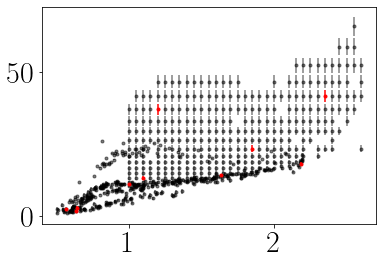

In [59]:
plt.errorbar(x, prot, yerr=prot_err, fmt="k.", alpha=.5, zorder=0)
# plt.errorbar(cluster_x_val, cluster_prot_val, yerr=cluster_prot_err_val, fmt="r.", alpha=1., zorder=1)
plt.errorbar(x_val, prot_val, yerr=prot_err_val, fmt="r.", alpha=1., zorder=1)

Fit GP model to data.

In [60]:
# filename = "../data/CV_gp_model.pkl"
# av.fit_gp(x, age, prot, prot_err, filename)

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1085.9993908632457 -> -1081.9739939433575
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1081.9739939433575 -> -1081.3543544466097
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1081.3543544466097 -> -1079.377411938135
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1079.377411938135 -> -1077.5470141227506
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1077.5470141227506 -> 192.28403777084003
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 192.28403777084003 -> 205.07095097371965


done


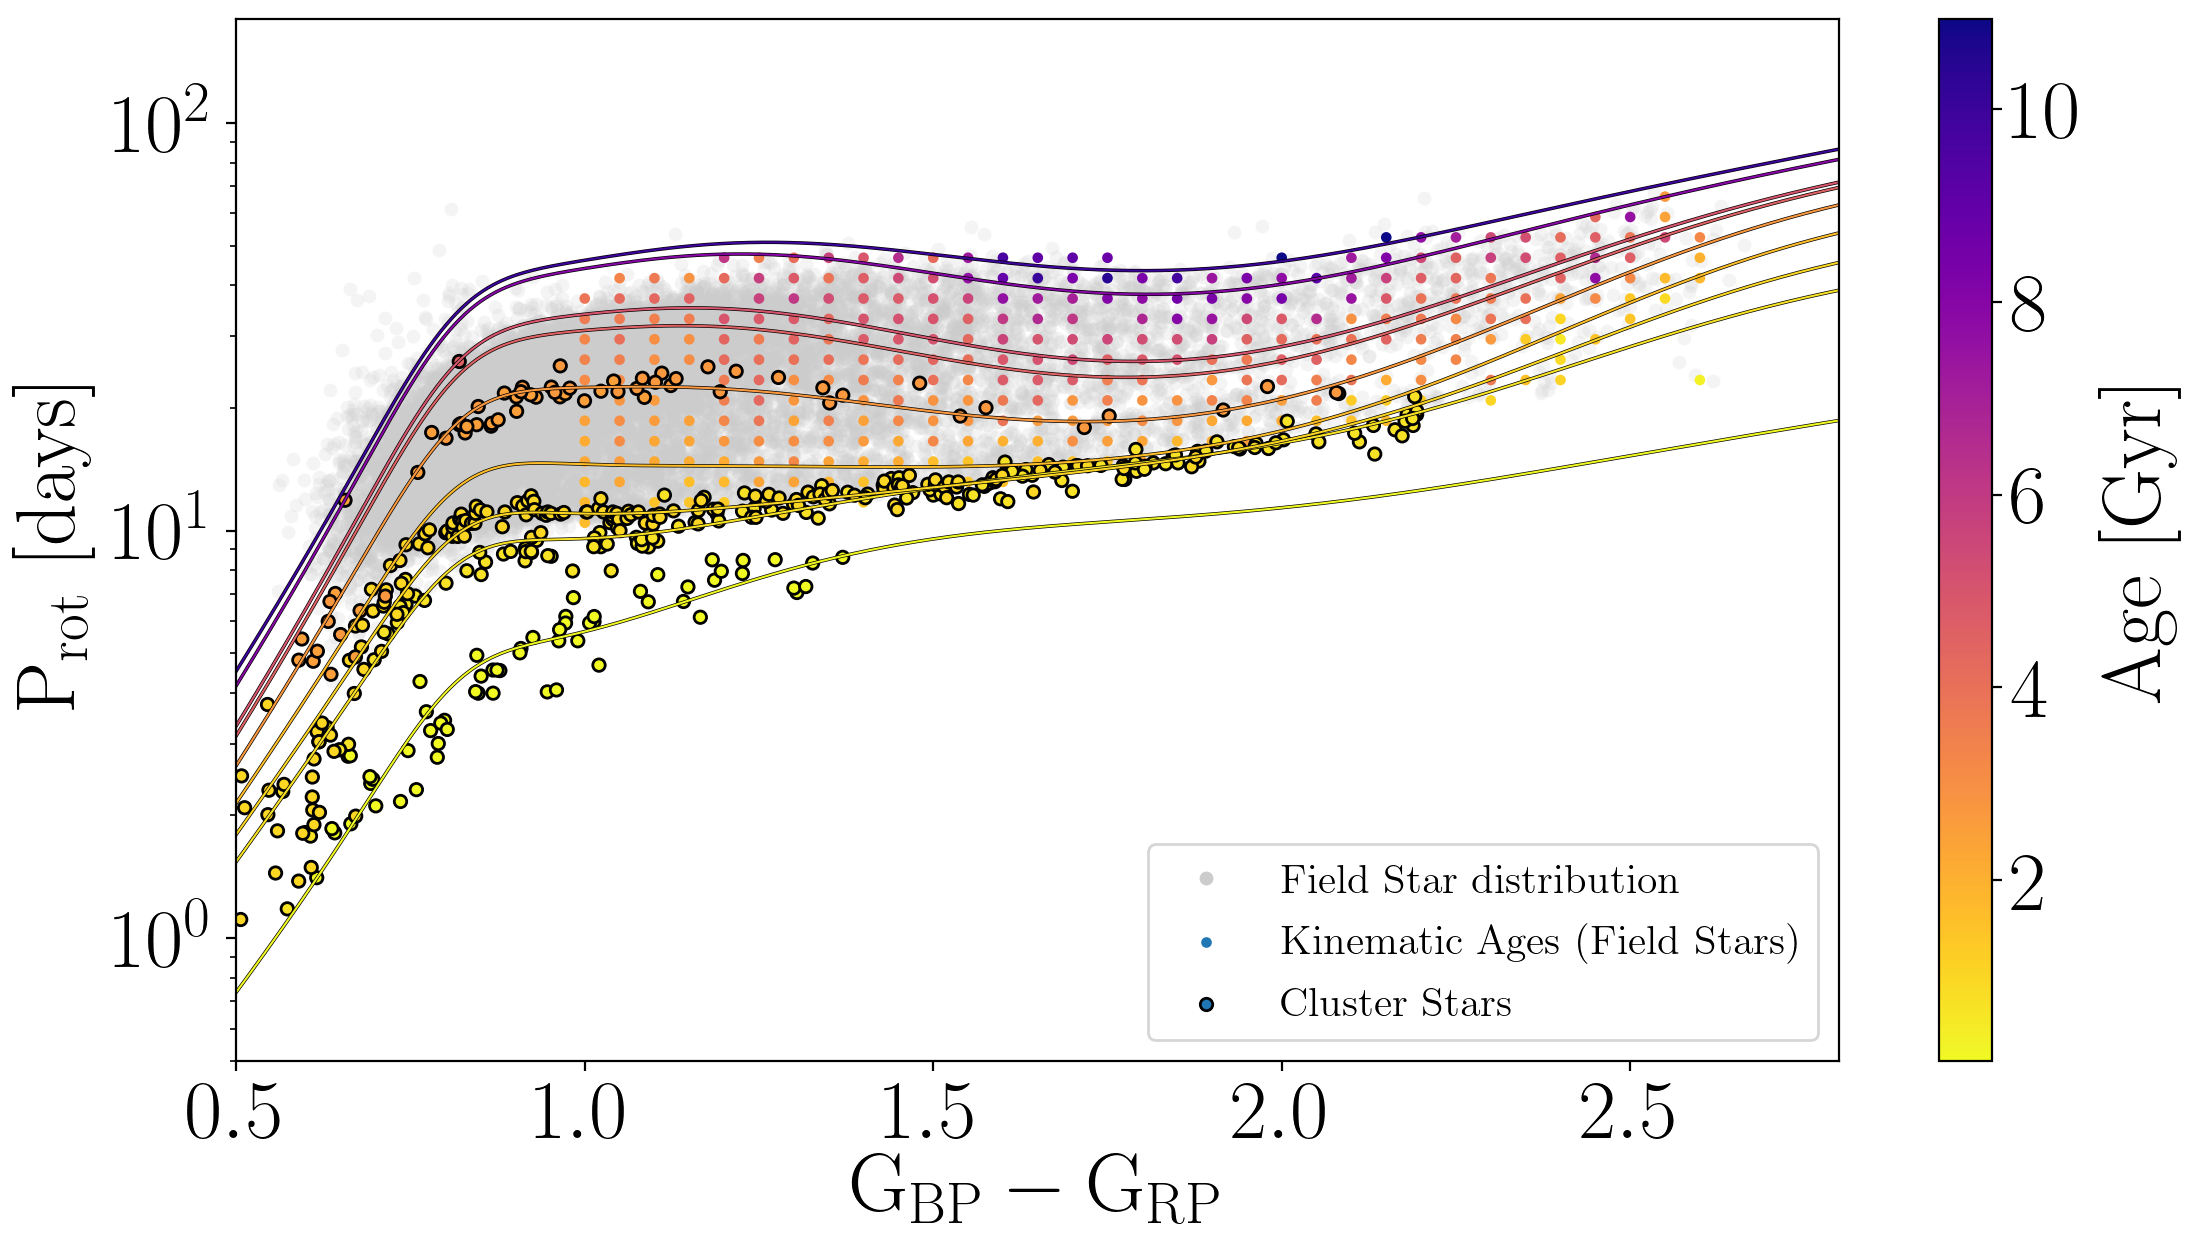

In [61]:
make_plot()

In [62]:
c_val = x_val
# prot_val = prot_val
# prot_err_val = prot_err_val
true_age_val = age_val

ap = AgePosterior(filename)

mu, mu_fit, sig = [np.zeros(len(c_val)) for i in range(3)]
for i in range(len(c_val)):
    lin_age_array, posterior = ap.get_post(c_val[i], prot_val[i], prot_err_val[i])
    age_array = np.log(lin_age_array)

    # Get mean and sigma of posterior. Adopt MAP as mu
    mu[i] = age_array[posterior == max(posterior)]
    
    g_init = apm.models.Gaussian1D(amplitude=1., mean=mu[i], stddev=.5)
    fit_g = apm.fitting.LevMarLSQFitter()
    g = fit_g(g_init, age_array, posterior)
    mu_fit[i], sig[i] = g.mean.value, g.stddev.value
        
#     plt.plot(age_array, posterior)
#     plt.plot(age_array, g(age_array))
#     plt.axvline(true_age_val[i], color="k")
#     plt.axvline(mu[i])
#     plt.axvline(mu_fit[i], color="C1")
#     plt.show()

(array([0.12      , 0.67      , 0.67      , 0.67      , 0.67      ,
        1.        , 1.94137432, 4.79629926, 4.79338648, 4.14604542]),
 array([-1.85017003, -0.87077415, -0.33066613, -0.86477295,  0.36667333,
         0.0210042 ,  0.33546709,  1.59571914,  1.34726945,  1.47089418]))

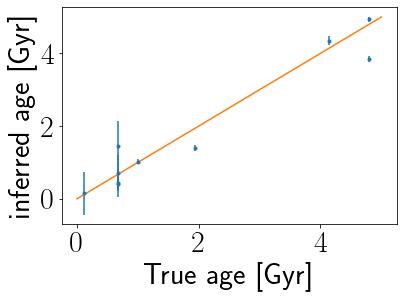

In [63]:
plt.errorbar(true_age_val, np.exp(mu), yerr=sig, fmt=".")
xs = np.linspace(0, 5, 100)
plt.plot(xs, xs)
plt.xlabel("True age [Gyr]")
plt.ylabel("inferred age [Gyr]")

true_age_val, mu

# plt.plot(color_array, posterior)
# plt.plot(color_array, fitted_model(color_array))
# plt.xlim(4, 5)